In [1]:
import os
from statistics import median
import numpy as np
import pandas as pd
import functools as ft
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
import math

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
class ProcessEvoSuiteData:
    """ Class that processes data from EvoSuite. """

    def __init__(self):
        self.name = "ProcessEvoSuiteData"

    def print_name(self):
        os.system(f"echo The name is: {self.name}")

    def calculate_medians60(self):
        """ Extract results from the EvoSuite results csv files with time bugdet 60. """

        # Read EvoSuite results
        res60 = pd.read_csv("res_data/results-60.csv")
        configuration_ids = ['weak_60', 'branch_60', 'default_60']
        
        # Sort by configuration
        res = res60.loc[:,['TARGET_CLASS', 'configuration_id', 'project.id', 'BranchCoverage']]
        result = res[res.apply(lambda row : row["configuration_id"] in configuration_ids, axis=1)]

        # Take medians of the 10 runs of EvoSuite per class
        medians = result.groupby(['TARGET_CLASS', 'configuration_id', 'project.id'])['BranchCoverage'].median()
        medians.to_csv('medians.csv')

        # Compute differences between BRANCH;WEAKMUTATION and BRANCH
        res_medians = pd.read_csv("medians.csv")
        res_medians.to_csv('res_medians.csv')
        return res_medians

    def run_statistical_tests(self, output_csv, search_budget, compared_function='branch'):
        res = pd.read_csv(output_csv)
        configuration_ids = ['weak_' + str(search_budget), 'branch_' + str(search_budget), 'default_' + str(search_budget)]

        # Sort by configuration
        res = res.loc[:,['TARGET_CLASS', 'configuration_id', 'project.id', 'BranchCoverage']]
        result = res[res.apply(lambda row : row["configuration_id"] in configuration_ids, axis=1)]

        # "weak" groups
        weak_result = result.loc[result['configuration_id'] == 'weak_' + str(search_budget)]
        weak_groups = weak_result.groupby(['TARGET_CLASS', 'configuration_id', 'project.id'])['BranchCoverage']

        # "branch" groups
        compared_func_result = result.loc[result['configuration_id'] == str(compared_function) + '_' + str(search_budget)]
        compared_func_groups = compared_func_result.groupby(['TARGET_CLASS', 'configuration_id', 'project.id'])['BranchCoverage']

        weak_classes = dict()
        for name, group in weak_groups:
            weak_classes[name] = group.astype(float).to_numpy()

        compared_func_classes = dict()
        for name, group in compared_func_groups:
            compared_func_classes[name] = group.astype(float).to_numpy()

        # If there are less than 10 runs for a class, pad the branch coverage with 0 
        def pad(val1, val2):
            if val1.shape[0] == val2.shape[0]:
                return val1, val2
            if val1.shape[0] < val2.shape[0]:
                return np.pad(val1, [(0, val2.shape[0]-val1.shape[0])]), val2
            else:
                return val1, np.pad(val2, [(0, val1.shape[0]-val2.shape[0])])

        # Calculate statistical significance per class
        # Do the Wilcoxon test for (weak_classes, compared_classes) per batch of 10 runs
        class_stats = dict()
        for ((key1, val1), (key2, val2)) in zip(weak_classes.items(), compared_func_classes.items()):
            val1, val2 = pad(val1, val2)
            stats, p = (-2,-2) if (np.sum(np.subtract(val1, val2)) == 0) else wilcoxon(val1, val2)
            class_stats[key1[0]] = p
            # print(str(key1) + str(val1) + ", "+ str(key2) + str(val2) + " HAS P VALUE OF: " + str(p))

        significant_class_stats = dict()
        for (key, pval) in class_stats.items():
            if (pval > -2 and pval < 0.05):
                significant_class_stats[key] = pval 
        
        # Return statistically significant class stats & all classes stats (stats = p-values)
        return significant_class_stats, class_stats
        

    def plot_stats(self, height, bars, comparison):
        
        # Create a dataset
        x_pos = np.arange(len(bars))

        # Create bars
        plt.bar(x_pos, height, color=['black', 'black', 'purple', 'purple', 'blue', 'blue'])

        # Name the x axis and the y axis and give title to whole graph
        plt.xlabel('Number of non-statistically (1st bar) & statistically significant (2nd bar) classes per search budget (60, 180, 300)')
        plt.ylabel('Time budget')
        plt.title('Number of statistically significant classes per time budget: ' + str(comparison))

        # Create names on the x-axis
        plt.xticks(x_pos, bars)
        
        plt.show()

    def get_ck_metrics(self):
        """ Will be used as features for the model. """

        class_metrics = pd.read_csv("ck_data/class.csv")
        class_metrics = class_metrics.iloc[:, 1:]
        return class_metrics
    
    def get_matching_classes_metrics(self, output_csv, search_budget):
        """Matches what the ck tool measured on the SF110 with the classes in EvoSuite output files."""
        
        class_metrics = data.get_ck_metrics()

        # Features are the metrics themselves: cbo, loc, etc.
        features = np.array(class_metrics.columns.values)[2:]

        res = pd.read_csv(output_csv)
        configuration_ids = ['weak_' + str(search_budget), 'branch_' + str(search_budget), 'default_' + str(search_budget)]

        # Sort by configuration
        res = res.loc[:,['TARGET_CLASS', 'configuration_id', 'project.id', 'BranchCoverage']]
        result = res[res.apply(lambda row : row["configuration_id"] in configuration_ids, axis=1)]

        # Match classes from ck tool result with classes in res_data (EvoSuite's output)
        matching_classes = class_metrics[class_metrics["class"].isin(result["TARGET_CLASS"])]

        # TODO check if the other way around is the same and remove potential duplicates
        # match_branch = result[result["TARGET_CLASS"].isin(class_metrics["class"])]
        
        # TODO there are classes that do not come from SF110 in the data from supervisors => rerun tool to cover those
        # then retrain model

        return matching_classes   

C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


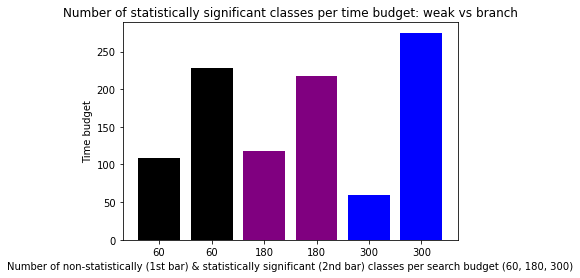

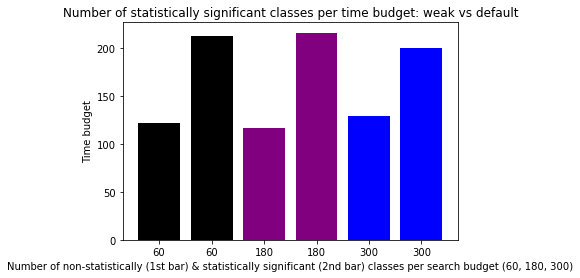

In [4]:
data = ProcessEvoSuiteData()

# matching = pd.DataFrame.from_dict(data.get_matching_classes_metrics("res_data/results-60.csv", 60))
# matching.head()

medians = data.calculate_medians60()
# print(medians)

res_dict = {}

# Contains statistically significant classes at [0] and all classes at [1]
# res_dict['stats60'][0].items() contains pairs of type (class_name, p-value)
res_dict["stats60"] = data.run_statistical_tests("res_data/results-60.csv", 60)
res_dict["stats180"] = data.run_statistical_tests("res_data/results-180.csv", 180)
res_dict["stats300"] = data.run_statistical_tests("res_data/results-300.csv", 300)

res_dict["stats60_default"] = data.run_statistical_tests("res_data/results-60.csv", 60, 'default')
res_dict["stats180_default"] = data.run_statistical_tests("res_data/results-180.csv", 180, 'default')
res_dict["stats300_default"] = data.run_statistical_tests("res_data/results-300.csv", 300, 'default')

# print(res_dict)

# Plot number of statistically significant classes for (weak - branch) and (weak - default) - 2nd bar
# along with the number of non statistical classes - in 1st bar
x_vals_branch = [
            len(res_dict["stats60"][1]) - len(res_dict["stats60"][0]), len(res_dict["stats60"][0])
          , len(res_dict["stats180"][1]) - len(res_dict["stats180"][0]), len(res_dict["stats180"][0])
          , len(res_dict["stats300"][1]) - len(res_dict["stats300"][0]), len(res_dict["stats300"][0])
          ]

x_vals_default = [
            len(res_dict["stats60_default"][1]) - len(res_dict["stats60_default"][0]), len(res_dict["stats60_default"][0])
          , len(res_dict["stats180_default"][1]) - len(res_dict["stats180_default"][0]), len(res_dict["stats180_default"][0])
          , len(res_dict["stats300_default"][1]) - len(res_dict["stats300_default"][0]), len(res_dict["stats300_default"][0])
          ]

y_vals = [60,60,180,180,300,300]

data.plot_stats(x_vals_branch, y_vals, comparison='weak vs branch')
data.plot_stats(x_vals_default, y_vals, comparison='weak vs default')

In [23]:
res_metrics_dict = {}

# Contains the dictionary with matched metrics (for classes from EvoSuite output and CK tool)
# Should probably be reindexed (or ignore index)
res_metrics_dict["class_metrics60"] = data.get_matching_classes_metrics("res_data/results-60.csv", 60)
# res_metrics_dict["class_metrics180"] = data.get_matching_classes_metrics("res_data/results-180.csv", 180)
# res_metrics_dict["class_metrics300"] = data.get_matching_classes_metrics("res_data/results-300.csv", 300)

# print(res_metrics_dict["class_metrics60"].keys())
# print(res_metrics_dict["class_metrics60"]['cbo'])

# Contains names of statistically significant classes
significant_classes = res_dict['stats60'][0].keys()

# Matched metrics for the significant classes
# TODO: repeat for different time budgets (180, 300)
matched_metrics60 = pd.DataFrame.from_dict(data.get_matching_classes_metrics("res_data/results-60.csv", 60))
signif_matched_metrics60 = matched_metrics60[matched_metrics60.apply(lambda row : row['class'] in significant_classes, axis=1)]

338
7         org.apache.commons.lang3.builder.HashCodeBuilder
23                         net.kencochrane.a4j.DAO.Product
389                  net.sourceforge.schemaspy.model.Table
552                      client.network.ForwardingObserver
1239                            Joshua.FoxHunt.HuntDisplay
                               ...                        
77123                        gnu.trove.impl.hash.TCharHash
77170    org.apache.lucene.search.exposed.compare.Named...
77550                   jigl.image.ops.ConnectedComponents
77574                                   fps370.Fps370Panel
77609                  net.sf.javaml.core.AbstractInstance
Name: class, Length: 338, dtype: object


In [ ]:
medians = data.calculate_medians60()[['TARGET_CLASS', 'configuration_id', 'BranchCoverage']]
medians

In [ ]:
X = []
classes = []

for cls in res_metrics_dict["class_metrics60"]['class'].items():
    # Select only those classes for which all 3 configuration data points are available
    if medians.loc[medians['TARGET_CLASS']==cls[1]].shape[0] != 3:
        continue
    X.append([])
    
    # Keep class names for later use
    # We need them to determine the proper labels
    classes.append(cls[1])
    
    # [2:] to skip the name and type
    for feature in res_metrics_dict["class_metrics60"].keys()[2:]:
        
        # X[-1] is the last (current) entry (class)
        # cls[0] is the id of the entry (class)
        # dict[class_metrics60][feature][cls[0]] is the specific feature
        # Of the current class
        feat = res_metrics_dict["class_metrics60"][feature][cls[0]]
        X[-1].append(feat if not math.isnan(feat) else 0)
    
print(len(X))
print(X)
# All features should have the same length
assert all(map(lambda x: len(x) == len(X[0]), X))

In [ ]:
labels_dict = {'branch_60':0, 'default_60':1, 'weak_60':2}
class_names = {0:'branch_60', 1:'default_60', 2:'weak_60'}
how_many = 0

def get_label(class_name, medians=medians, labels_dict=labels_dict):
    global how_many
    # Get matching rows
    selected_rows = medians.loc[medians['TARGET_CLASS']==class_name]
    assert selected_rows.shape[0] == 3, f"Expected 3 selected rows, but got {selected_rows[0]}"
    
    # Get the maximum branch covreage of the three data points
    max_coverage = selected_rows.max(numeric_only=True)['BranchCoverage']
    
    # Select the configuration_id by the maximum branch coverage
    # TODO: decide on a policy for equality
    # A lot of the datapoints have equal values, so this is an extremely important decision
    # Currently: just pick the last one
    max_rows = selected_rows.loc[selected_rows['BranchCoverage']==max_coverage]
    
    # Count the number of labels that have non-unique maximums
    if max_rows.shape[0] > 1:
        how_many += 1
        
    # Select the first row of the maximum ones
    max_config_id = max_rows.iloc[-1]['configuration_id']
    
    assert max_config_id in labels_dict, f"Expected configuration id to be one of {labels_dict.keys()}, but got {max_config_id}"
    return labels_dict[max_config_id]


y = list(map(get_label, filter(lambda cls: , classes)))
print(f"Non-unique maximums for {how_many} out of {len(X)} entries")
print(y)
assert len(y) == len(X), f"X and y should have the same number of entries, but they have {len(X)} and {len(y)}, respectively."
    

In [ ]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC

clf = SVC()
clf.set_params(kernel='linear').fit(X, y)
clf.predict(X[:5])
# clf.set_params(kernel='rbf').fit(X, y)
# clf.predict(X[:5])

In [ ]:
# Source towardsdatascience.com: 
# https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575
def print_feature_importance(names_array, importances_array):    
    """ Prints out a feature importance array as a dataframe. """
    
    importances = pd.DataFrame(data=names_array)
    importances[1] = importances_array    
    importances = importances.T
    importances.drop(0, axis=0, inplace=True)
    importances.columns = feature_names
    
    print(str(importances.reset_index(drop=True)))
    return


def build_tree(features, targets, feature_names, class_names):    
    """ Builds a decision tree.
        Prints out the decision tree 1) as a plot, 2) as text.
        Also outputs: 1) feature importance, 2) training set and test set mean accuracy of tree
    
        :param features: model features
        :param targets: model targets
        :param feature_names: names of the dataset features
    """
  
    train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size=0.2, random_state=123)
    decision_tree = tree.DecisionTreeClassifier(random_state=456)
    decision_tree = decision_tree.fit(train_features, train_targets)    # Visualizing the decision tree
    
    # 1. Saving the image of the decision as a png       
    plt.subplots(figsize=(17, 12))
    tree.plot_tree(decision_tree, feature_names=feature_names, filled=True, rounded=True, class_names=class_names)
    plt.savefig("decision_tree.png")    
    # 2. Output the tree as text in the console
    tree_as_text = tree.export_text(decision_tree, feature_names=feature_names)
    print(tree_as_text)    
    # Feature Importance
    # Turns the feature importance array into a dataframe, so it has a table-like output format
    print_feature_importance(feature_names, decision_tree.feature_importances_)    
    # Training and test mean accuracy
    train_error = np.round(decision_tree.score(train_features, train_targets), 2)
    test_error = np.round(decision_tree.score(test_features, test_targets), 2)
    
    print("Training Set Mean Accuracy = " + str(train_error))
    print("Test Set Mean Accuracy = " + str(test_error))
    return
 
build_tree(X, y, res_metrics_dict["class_metrics60"].keys()[2:], class_names)